# Tweet Classifier
[tweets](https://www.kaggle.com/kazanova/sentiment140)


# Utilities, Constants

In [1]:
def calculate_percent_missing(in_df):
    # function which returns a dataframe indicating what percent of a column is missing
    percent_missing = in_df.isnull().sum() * 100 / len(in_df)
    return pd.DataFrame({'percent_missing': percent_missing})
def summary_of_model(clf, X_train, X_test, y_train, y_test):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
    # This provides a summary of the model, but without the threshold condition.
    # It includes a summary on recall/accuracy on the training and test sets, a visual display of the confusion matrix
    # and a plot of the precision-recall curve for a given classifier.
    pred_test = clf.predict(X_test)
    pred_train = clf.predict(X_train)
    print(classification_report(y_test, pred_test))
    print('Recall on the training set: {:.2f}'.format(recall_score(y_train, pred_train)))
    print('Accuracy on the training set: {:.2f}'.format(accuracy_score(y_train, pred_train)))
    print('Recall on the test set: {:.2f}'.format(recall_score(y_test, pred_test)))
    print('Accuracy on the test set: {:.2f}'.format(accuracy_score(y_test, pred_test)))
    print(confusion_matrix(y_test, pred_test))
    _, ax = plt.subplots(figsize=(9,9))
    ax = sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='d', cmap='vlag', annot_kws={"size": 40, "weight": "bold"})  
    labels = ['False', 'True']
    ax.set_xticklabels(labels, fontsize=25);
    ax.set_yticklabels(labels, fontsize=25);
    ax.set_ylabel('Actual', fontsize=30);
    ax.set_xlabel('Prediction', fontsize=30)
    lr_probs = clf.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    plt.figure()
    plt.plot(lr_recall, lr_precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [2]:
TEST_FRACTION = .25 #percentage of the test size
CV = 7 #cross validations to do in grid search
OPT_ON = 'f1' #what to optimize in gridsearches
N_JOBS = 7 #number of cores
RAND_STATE = 0 #will be doing multiple train-test-splits, and want to keep everything random, but do the same train-test-splits

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
import tensorflow as tf
from tensorflow.keras import layers
import nlp
tokenizer = TweetTokenizer()

In [4]:
data = pd.read_csv('data/tweets.csv', encoding = 'Latin-1', names=('sentiment','id','date','flag','username','tweet'))
data = data[['sentiment', 'tweet']]

In [5]:
data = data.sample(frac=1)
#data = data.head(50000)

In [6]:
%load_ext tensorboard
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
VOCAB_SIZE=10000
MAXLEN=50
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x==4 else 0)

In [9]:
import nltk, re, string
nltk.download("stopwords")
def clean_tweet(tweet:str):
    #lowercase
    tweet = tweet.lower()
    #tweet = re.sub(r'https?:\/\/.*[\r\n]* ', '', str(tweet)) #TODO: fix this link remover, it currently deletes everything beyond the link
    tweet = re.sub(r'#', '', str(tweet)) #remove hashtab
    
    #remove punctuation
    punct = set(string.punctuation)
    tweet = "".join(ch for ch in tweet if ch not in punct)
    return tweet

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jcummings/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data['tweet'] = data['tweet'].apply(clean_tweet)

In [11]:
tweets = data['tweet'].to_numpy()
sentiments = data['sentiment'].to_numpy()

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

In [14]:
tokenizer.fit_on_texts(tweets)

<AxesSubplot:ylabel='Count'>

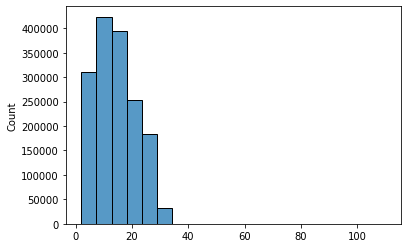

In [15]:
lengths = [len(t.split(' ')) for t in tweets]
sns.histplot(lengths, bins = 20)

In [16]:
maxlen = 35
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def seq_padder(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [18]:
padded_tweets = seq_padder(tokenizer, tweets)

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 16, input_length=maxlen),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40)),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(padded_tweets, sentiments, test_size=.05)

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, 
#               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
#              )

In [27]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = dataset_test.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset_train, dataset_test)

<BatchDataset shapes: ((512, 35), (512,)), types: (tf.int32, tf.int64)> <BatchDataset shapes: ((512, 35), (512,)), types: (tf.int32, tf.int64)>


In [ ]:
h = model.fit(dataset_train, validation_data = dataset_test, epochs=20, 
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)]
             )

Epoch 1/20
2688/2968 [==========================>...] - ETA: 40s - loss: 0.4443 - accuracy: 0.7906

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy :', accuracy)